In [1]:
#visualisation
import pathlib
import matplotlib.pyplot as plt
import cv2
import imghdr
#numpy / pandas / os
import os
import numpy as np 
import pandas as pd 

import shutil
import random

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

#tensorflow 
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras
import tensorflow.keras.utils
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

2024-03-05 19:30:00.758525: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 19:30:00.758575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 19:30:00.760036: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#define required variable
random_seed = 42
EPOCHS = 20
BATCH_SIZE = 32
IMAGE_SIZE = 256

# Exploring Data

In [3]:
#storing dataset path in path variable
path = '/kaggle/input/v2-plant-seedlings-dataset/'

In [4]:
#storing class names in seedlings_names to use furthor
seedlings_names = os.listdir(path)
seedlings_names

['Scentless Mayweed',
 'Common wheat',
 'nonsegmentedv2',
 'Charlock',
 'Black-grass',
 'Sugar beet',
 'Loose Silky-bent',
 'Maize',
 'Cleavers',
 'Common Chickweed',
 'Fat Hen',
 'Small-flowered Cranesbill',
 'Shepherd’s Purse']

In [5]:
#print classes and their counts
total = 0
for name in seedlings_names:
  classpath = os.path.join(path,name)
  l = len(os.listdir(classpath))
  print("{} : {}".format(name, l))
  total += l
print("Total : {}".format(total))

Scentless Mayweed : 607
Common wheat : 253
nonsegmentedv2 : 12
Charlock : 452
Black-grass : 309
Sugar beet : 463
Loose Silky-bent : 762
Maize : 257
Cleavers : 335
Common Chickweed : 713
Fat Hen : 538
Small-flowered Cranesbill : 576
Shepherd’s Purse : 274
Total : 5551


In [6]:
#folder nonsegmentedv2 contains other folder to check that getting its path
if 'nonsegmentedv2' in seedlings_names:
    sub_name = os.listdir(path+'/nonsegmentedv2')

In [7]:
#print folder structure inside of folder nonsegmentedv2 and file counts
total = 0
for name in sub_name:
  classpath = os.path.join(path+'/nonsegmentedv2',name)
  l = len(os.listdir(classpath))
  print("{} : {}".format(name, l))
  total += l
print("Total : {}".format(total))

Scentless Mayweed : 607
Common wheat : 253
Charlock : 452
Black-grass : 309
Sugar beet : 463
Loose Silky-bent : 762
Maize : 257
Cleavers : 335
Common Chickweed : 713
Fat Hen : 538
Small-flowered Cranesbill : 576
Shepherd’s Purse : 274
Total : 5539


In [8]:
#clearly we can see from above cell nonsegmentedv2 is duplicate of our dataset 
#so removing nonsegmentedv2 from list
if 'nonsegmentedv2' in seedlings_names:
    index = seedlings_names.index('nonsegmentedv2')
    seedlings_names = seedlings_names[:index]+seedlings_names[index+1:]
print(seedlings_names)
len(seedlings_names)

['Scentless Mayweed', 'Common wheat', 'Charlock', 'Black-grass', 'Sugar beet', 'Loose Silky-bent', 'Maize', 'Cleavers', 'Common Chickweed', 'Fat Hen', 'Small-flowered Cranesbill', 'Shepherd’s Purse']


12

# Displayig one sample image from datset

(325, 325, 3)

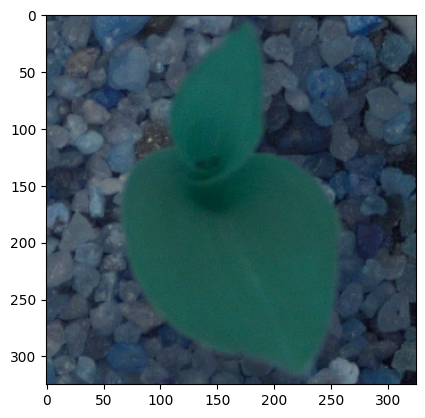

In [9]:
#Displaying one image from dataset
sample = os.listdir(path)[7]
img = os.listdir(os.path.join(path,sample))[3]
img2 = cv2.imread(os.path.join(path,sample,img))


plt.imshow(img2)
img2.shape

In [10]:
#print size of 2 images from each class
for sample in seedlings_names:
  for j in range(2):
    img = os.listdir(os.path.join(path,sample))[j]
    img2 = cv2.imread(os.path.join(path,sample,img))
    print(img2.shape)

(735, 735, 3)
(148, 148, 3)
(562, 562, 3)
(710, 710, 3)
(316, 316, 3)
(195, 195, 3)
(170, 170, 3)
(283, 283, 3)
(592, 592, 3)
(339, 339, 3)
(197, 197, 3)
(618, 618, 3)
(692, 692, 3)
(655, 655, 3)
(347, 347, 3)
(186, 186, 3)
(130, 130, 3)
(336, 336, 3)
(196, 196, 3)
(300, 300, 3)
(169, 169, 3)
(210, 210, 3)
(276, 276, 3)
(104, 104, 3)


From output of above cell it is clear that each image is in different size we will resize it furthor

# Spliting dataset into Train dataset, validation data set and Test dataset

Creating train folder,val folder and test folder and copying shuffled images from our original dataset

In [11]:

# creating train / val /test
dataset_path = path
new_dataset_path = '/kaggle/working/dataset/'
classes = seedlings_names

if os.path.exists(new_dataset_path):
    shutil.rmtree(new_dataset_path)
 
for cls in classes:
    os.makedirs(new_dataset_path+ 'train/' + cls)
    os.makedirs(new_dataset_path +'val/' + cls)
    os.makedirs(new_dataset_path + 'test/' + cls)
    
## creating partition of the data after shuffeling

for cls in classes:
    src = dataset_path + cls # folder to copy images from
    print(src)

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)

    ## here 0.75 = training ratio , (0.95-0.75) = validation ratio , (1-0.95) =  
    ##training ratio  
    train_FileNames,val_FileNames,test_FileNames = np.split(np.array(allFileNames),[int(len(allFileNames)*0.75),int(len(allFileNames)*0.90)])

    # #Converting file names from array to list

    train_FileNames = [src+'/'+ name for name in train_FileNames]
    val_FileNames = [src+'/' + name for name in val_FileNames]
    test_FileNames = [src+'/' + name for name in test_FileNames]
    
    ## Copy pasting images to target directory

    for name in train_FileNames:
        shutil.copy(name, new_dataset_path+'train/'+cls )
    for name in val_FileNames:
        shutil.copy(name, new_dataset_path+'val/'+cls )
    for name in test_FileNames:
        shutil.copy(name,new_dataset_path+'test/'+cls )

/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed
/kaggle/input/v2-plant-seedlings-dataset/Common wheat
/kaggle/input/v2-plant-seedlings-dataset/Charlock
/kaggle/input/v2-plant-seedlings-dataset/Black-grass
/kaggle/input/v2-plant-seedlings-dataset/Sugar beet
/kaggle/input/v2-plant-seedlings-dataset/Loose Silky-bent
/kaggle/input/v2-plant-seedlings-dataset/Maize
/kaggle/input/v2-plant-seedlings-dataset/Cleavers
/kaggle/input/v2-plant-seedlings-dataset/Common Chickweed
/kaggle/input/v2-plant-seedlings-dataset/Fat Hen
/kaggle/input/v2-plant-seedlings-dataset/Small-flowered Cranesbill
/kaggle/input/v2-plant-seedlings-dataset/Shepherd’s Purse


In [12]:
#print our new folder structure
print(os.listdir(new_dataset_path))
print(os.listdir(new_dataset_path+'train'))
print(os.listdir(new_dataset_path+'test'))
print(os.listdir(new_dataset_path+'val'))

['test', 'val', 'train']
['Black-grass', 'Common wheat', 'Fat Hen', 'Sugar beet', 'Common Chickweed', 'Cleavers', 'Charlock', 'Loose Silky-bent', 'Scentless Mayweed', 'Maize', 'Shepherd’s Purse', 'Small-flowered Cranesbill']
['Black-grass', 'Common wheat', 'Fat Hen', 'Sugar beet', 'Common Chickweed', 'Cleavers', 'Charlock', 'Loose Silky-bent', 'Scentless Mayweed', 'Maize', 'Shepherd’s Purse', 'Small-flowered Cranesbill']
['Black-grass', 'Common wheat', 'Fat Hen', 'Sugar beet', 'Common Chickweed', 'Cleavers', 'Charlock', 'Loose Silky-bent', 'Scentless Mayweed', 'Maize', 'Shepherd’s Purse', 'Small-flowered Cranesbill']


In [13]:
#storing paths for train dataset, validation dataset and test dataset in variable train_path, test_path 
# and val_path

train_path = new_dataset_path+'train'
test_path = new_dataset_path+'test'
val_path = new_dataset_path+'val'

# Loading train data, validation data and test data

Loading training data, tesing data and validation data into tensors train_tf, test_tf and val_tf using paths train_path, test_path and val_path 

In [14]:
#loading train data into train_tf
train_tf = tensorflow.keras.utils.image_dataset_from_directory(
    train_path, 
    shuffle=True,
    class_names=seedlings_names,
    seed=random_seed,
    batch_size=BATCH_SIZE, 
    image_size= (IMAGE_SIZE,IMAGE_SIZE)
)

Found 4149 files belonging to 12 classes.


In [15]:
#loading test data into test_tf
test_tf = tensorflow.keras.utils.image_dataset_from_directory(
    test_path, 
    shuffle=True,
    class_names=seedlings_names,
    seed=random_seed,
    batch_size=BATCH_SIZE, 
    image_size= (IMAGE_SIZE,IMAGE_SIZE)
)

Found 560 files belonging to 12 classes.


In [16]:
#loading validation data into val_tf
val_tf = tensorflow.keras.utils.image_dataset_from_directory(
    val_path, 
    shuffle=True,
    class_names=seedlings_names,
    seed=random_seed,
    batch_size=BATCH_SIZE, 
    image_size= (IMAGE_SIZE,IMAGE_SIZE)
)

Found 830 files belonging to 12 classes.


# Exploring training data 

In [17]:
# to see data we converting tensor into numpy iterator
data_iterator = train_tf.as_numpy_iterator()

In [18]:
# we using next() to acces data batch wise
batch = data_iterator.next()



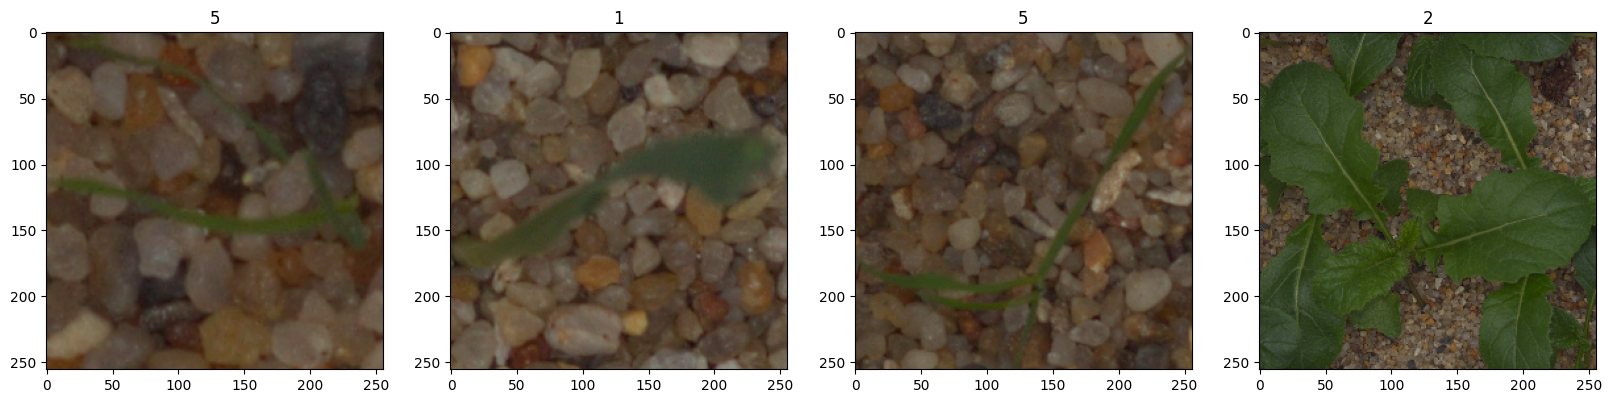

In [19]:
#displaying 4 images of 1 batch
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

In [20]:
#batch is tuple first element is image data and second element label
#print shape of image data
print(batch[0].shape)
#print shape of label
print(batch[1].shape)

#print data of first image and labels of all image in batch
print(batch[0][:1])
print(batch[1])

(32, 256, 256, 3)
(32,)
[[[[ 61.        39.        23.      ]
   [ 63.802734  41.802734  25.802734]
   [ 66.53516   44.26758   28.267578]
   ...
   [ 48.929688  37.66211   34.39453 ]
   [ 51.757812  40.757812  37.31836 ]
   [ 54.        43.        39.      ]]

  [[ 62.68164   42.36328   26.363281]
   [ 63.5991    42.652313  26.652313]
   [ 64.70352   43.146484  27.146484]
   ...
   [ 49.529648  38.672626  34.99449 ]
   [ 52.004147  41.811028  37.811028]
   [ 54.560547  44.68164   40.121094]]

  [[ 64.53516   46.070312  29.802734]
   [ 64.1246    44.538662  28.421074]
   [ 64.14191   43.53387   27.605469]
   ...
   [ 50.339176  39.875618  36.143196]
   [ 51.641727  42.08118   37.791718]
   [ 53.39453   44.39453   39.39453 ]]

  ...

  [[ 96.07031   60.535156  29.070312]
   [ 96.37029   60.685146  28.809746]
   [ 95.92712   59.928402  27.39196 ]
   ...
   [119.87562  100.143196  78.143196]
   [120.471855 100.471855  78.79372 ]
   [120.73242  100.73242   79.46484 ]]

  [[ 93.68164   60.  

From the output of above cell image data is not normalize it varies from 0 to 256 we have to make its values between 0 and 1 for that we will using augmentation layers in model

### Creating Resize and Rescaling layer using tensor

In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1.0/255)
])

### checking classes distribution

In [22]:
#count images in each class in train directory
count = []
for name in seedlings_names:
  classpath = os.path.join(train_path,name)
  count.append(len(os.listdir(classpath)))
count

[455, 189, 339, 231, 347, 571, 192, 251, 534, 403, 432, 205]

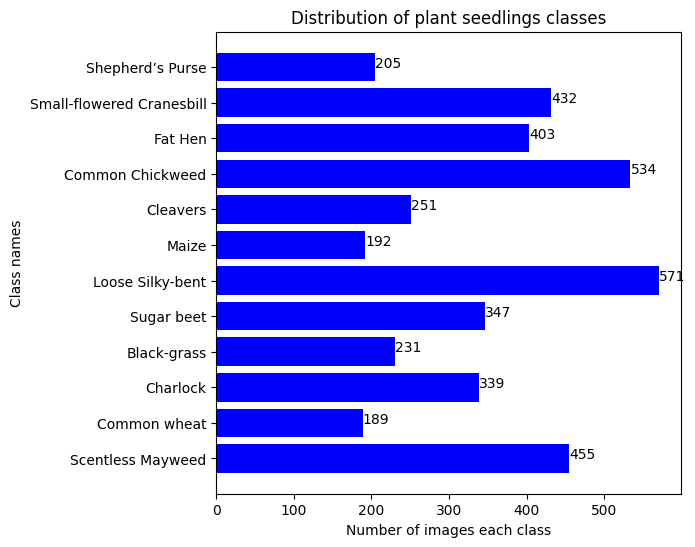

In [23]:
plt.figure(figsize=(6,6))
plt.barh(seedlings_names,count,color='blue')
for index, value in enumerate(count):
    plt.text(value, index,str(value))
plt.xlabel("Number of images each class")
plt.ylabel("Class names")
plt.title("Distribution of plant seedlings classes")
plt.show()

From above graph we can say the training data set is unblanced

### Creating class weights for unbalanced class

In [24]:
#defining a method to return labels of tensor flow
def get_labels(data_tf):
    labels=[]
    for i , j in data_tf.take(len(data_tf)):
        labels = labels + list(j.numpy())
    
    return labels


In [25]:
# here we geting class weights for training dataset labels using compute_class_weight from sklearn
train_labels = get_labels(train_tf)

weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)

weights = dict(enumerate(weights))

In [26]:
weights

{0: 0.7598901098901099,
 1: 1.8293650793650793,
 2: 1.0199115044247788,
 3: 1.4967532467532467,
 4: 0.9963976945244957,
 5: 0.6055166374781086,
 6: 1.80078125,
 7: 1.3774900398406376,
 8: 0.6474719101123596,
 9: 0.857940446650124,
 10: 0.8003472222222222,
 11: 1.6865853658536585}

### Data augmentation

we creating a layer to create extra images by rotation of image and Random flip.so our model can predict if image is rotated also

In [27]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3)
])

# Model

### Build model

In [38]:
model = Sequential()

In [39]:
model.add(resize_and_rescale)
model.add(data_augmentation)

model.add(Conv2D(32, (3,3), strides=(2,2), activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(4,4))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(3,3))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(12, activation='softmax'))

In [40]:
model.build(input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3))

model.compile(
    'adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 127, 127, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 58, 58, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 12, 12, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 10, 10, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 3, 3, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 1152)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 128)              │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 12)               │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 463,820 (1.77 MB)

 Trainable params: 463,820 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [41]:
#creating logs for callback
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [42]:
#train the model using fit method on train dataset train_tf and validation dataset val_tf
hist = model.fit(
    train_tf,
    validation_data=val_tf,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[tensorboard_callback],
    class_weight=weights
)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.0960 - loss: 2.4881 - val_accuracy: 0.2855 - val_loss: 1.9063
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.3261 - loss: 1.8326 - val_accuracy: 0.3807 - val_loss: 1.6271
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.4019 - loss: 1.5859 - val_accuracy: 0.4771 - val_loss: 1.4127
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.4755 - loss: 1.4069 - val_accuracy: 0.5578 - val_loss: 1.2679
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.5447 - loss: 1.2484 - val_accuracy: 0.5602 - val_loss: 1.1649
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.5907 - loss: 1.1032 - val_accuracy: 0.6036 - val_loss: 1.0694
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.6526 - loss: 0.9495 - val_accuracy: 0.7133 - val_loss: 0.8648
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.6985 - loss: 0

In [43]:
#evaluating the model on testing dataset test_tf
model.evaluate(test_tf)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.8741 - loss: 0.3510


[0.3465561866760254, 0.875]

# Evalution

## Plot performance

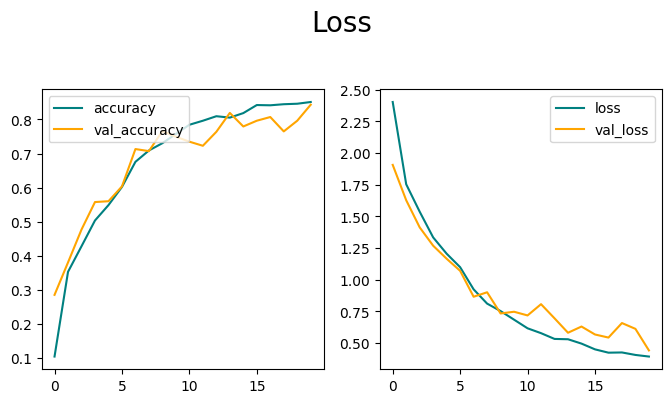

In [44]:
#ploting graph for training acurracry vs validation accuracy and 
# training loss vs validation loss
fig = plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")

plt.subplot(2,2,2)
plt.plot(range(EPOCHS),hist.history['loss'], color='teal', label='loss')
plt.plot(range(EPOCHS),hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

In [45]:
#printing classification report for model with test data predictions
y_true = []
y_pred = []
for images, labels in test_tf.take(len(test_tf)):
    y_true = y_true+list(labels.numpy())
    y_pred = y_pred +[np.argmax(i) for i in model.predict(images)]
print(classification_report(y_true, y_pred, target_names=seedlings_names))
              

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
                           precision    recall  f1-score   support

        Scentless Mayweed       0.88      0.85      0.87        61
             Common wheat       0.85      0.88      0.87        26
                 Charlock       1.00      0.87      0.93        46
              Black-grass       0.64      0.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


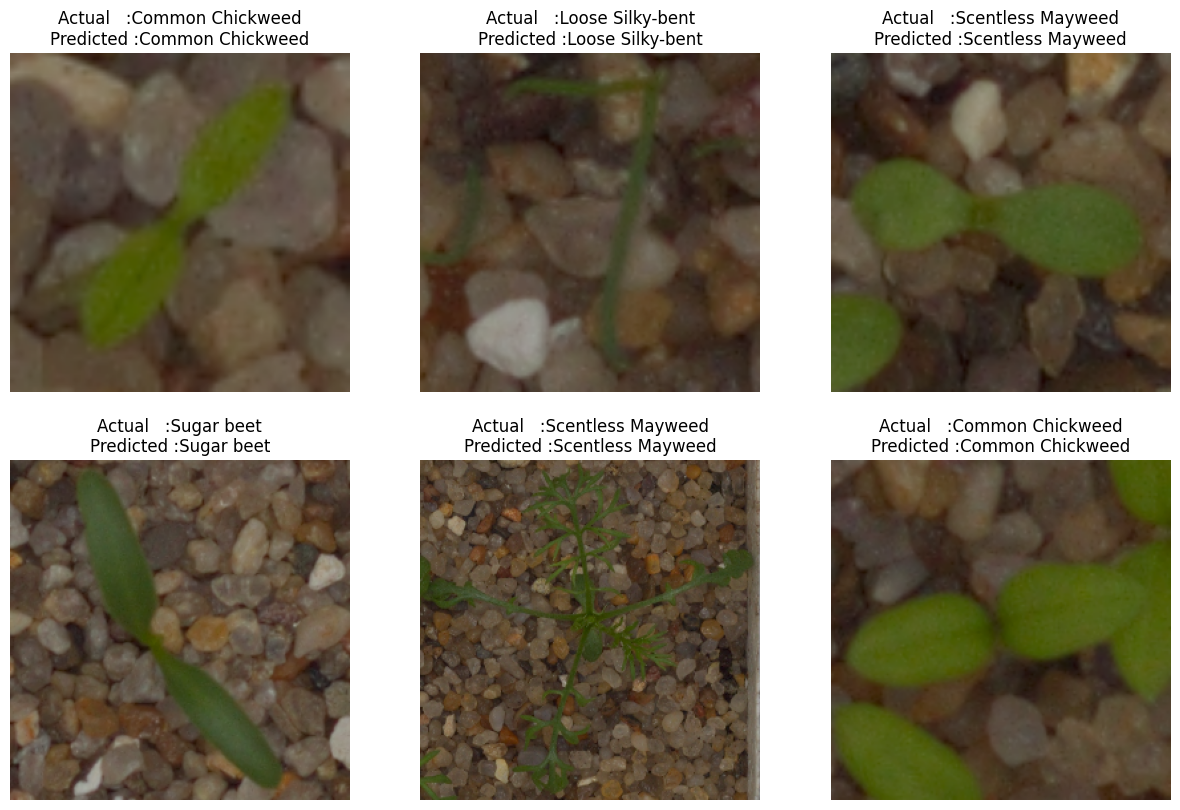

In [48]:
#printing 6 images with actual label and preddicted labels
plt.figure(figsize=(15,15))
for images, labels in test_tf.take(1):
    for i in range(6):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predictions = model.predict(images)
        
        predicted_class = seedlings_names[np.argmax(predictions[i])]
        
        actual_class = seedlings_names[labels[i].numpy()]
        
        plt.title(f"Actual   :{actual_class}\nPredicted :{predicted_class}")
        
        plt.axis("off")
    plt.show()
    

In [49]:
#saving model
model_version=1
model.save(f"/kaggle/working//model{model_version}.keras")